In [1]:
import fnmatch, re, os
import json

def parametrizedFileSelection(fileDirectory, fileArguments):
    files = []
    
    for k,v in fileArgs.items():
        if type(v) is not list:
            fileArgs[k] = [v]
        
    for file in os.listdir(fileDirectory):
        for key in fileArguments:
            match = False
            for value in fileArguments[key]:
                expression = key + "=" + str(value)
                if expression + ',' in file or expression + '_' in file:
                    match = True
            if match == False:
                break
    
        if match == True:
            files.append(file)
        
    return files


# Experiment factors
Communs
- filename
- nWorkers
------- order based ------------
- voterSeed
- nVoters
--------Community detection based----------
- comDet
- assignment
- withBoundary (false si order based)
--------- Other ----------
- distType (close/far)
- minDist 

Pour un même nombre de worker on fait varier la seed (cas order based)

In [ ]:
import pandas as pd
import numpy as np

fileDirectory = "../outputs/"

# fileArgs = { "nWorkers": 10, "voterSeed": 0, "minDist": "1"}
fileArgs = { "nWorkers": 807}      
files = parametrizedFileSelection(fileDirectory, fileArgs)

filesData = []

for file in files:
    with open(fileDirectory + file) as json_file:
        data = json.load(json_file)
        filesData.append(data)        
       # print(len(data['candidates'][0]) ,"-", len(data['candidates']), data['candidates'])
df = pd.DataFrame(filesData)

df.head()

In [ ]:
import matplotlib.pyplot as plt

largestCliqueSize = lambda x : len(x[0])
largestCliqueCount = lambda x : len(x)


largestCliqueSizeData = df["candidates"].apply(largestCliqueSize)
largestCliqueCountData = df["candidates"].apply(largestCliqueCount)


fig1, ax1 = plt.subplots(ncols=2)
ax1[0].set_title('CliqueSize')
ax1[0].set_yscale('log')
ax1[0].boxplot(largestCliqueSizeData)

ax1[1].set_title('CliqueSize')
ax1[1].set_xscale('log')
ax1[1].set_yscale('log')
ax1[1].set_xlabel('clique size')


ax1[1].hist(largestCliqueSizeData, bins=np.arange(0,500,5))

fig2, ax2 = plt.subplots(ncols=2)
ax2[0].set_title('CliqueCount')
ax2[0].set_yscale('log')
ax2[0].boxplot(largestCliqueCountData)
ax2[1].set_title('CliqueCount')
ax2[1].set_xlabel('candidate count')
ax2[1].set_xscale('log')
ax2[1].set_yscale('log')


ax2[1].hist(largestCliqueCountData, bins=np.arange(0,500,5))

## Distribution du nombre de workers distants en fonction de la seed utilisée

In [ ]:
from scipy import stats
import numpy as np

seeds = list(range(0,101))
# seeds = ["NA"]
otherWorkersDistance = lambda x : x["other"]

data = []

for seed in seeds:
    filterOnSeed = df.where(df["voterSeed"] == seed).dropna()
    print(filterOnSeed)
    otherWorkersDistanceData = filterOnSeed.head(1)["workerDistances"].apply(otherWorkersDistance)
    data.append(otherWorkersDistanceData.tolist()[0])

newData = np.zeros((10,len(seeds)), dtype=int)
for x,l in enumerate(data):
    for y in range(0,len(l)):
        newData[x][y] = l[y]


df2 = pd.DataFrame(newData, columns=range(-1,9))

df2 = df2.apply(lambda x : x//2) #remove bidirectionnal links

fig1, ax1 = plt.subplots(nrows=5, ncols=2, figsize=(4*2,3*5))
for index, column in enumerate(df2.columns):
    ax1[index//2][index%2].set_title('Distance = ' + str(column))
    ax1[index//2][index%2].hist(df2[column])

Commentaire : pas de loi normale (pour l'instant) -> a tester avec les 100 seeds

## Evolution du nombre de workers dans les cliques maximales en fonction de la distance maximale entre workers

In [5]:
def formatToDict(df):
    candidatesByMinDist = {}
    for idx, row in df.iterrows():
        candidatesByMinDist[row["minDist"]] = row["candidates"]
    return candidatesByMinDist

In [6]:
df.head()
df = df[[
    'filename',
    'nWorkers',
    'voterSeed',
    'comDet',
    'assignment',
    'withBoundary',
    'distType',
    'candidates',
    'minDist'
]]
cols = df.columns[:-2].tolist()
groupDf = df.groupby(by=cols)[['candidates', 'minDist']].apply(formatToDict)

cliqueNumber = [ { k:len(v) for k,v in element.items() } for element in groupDf ]
cliqueSize = [ { k:len(v[0]) for k,v in element.items() } for element in groupDf ]


nbRows=len(groupDf)
nbCol=3


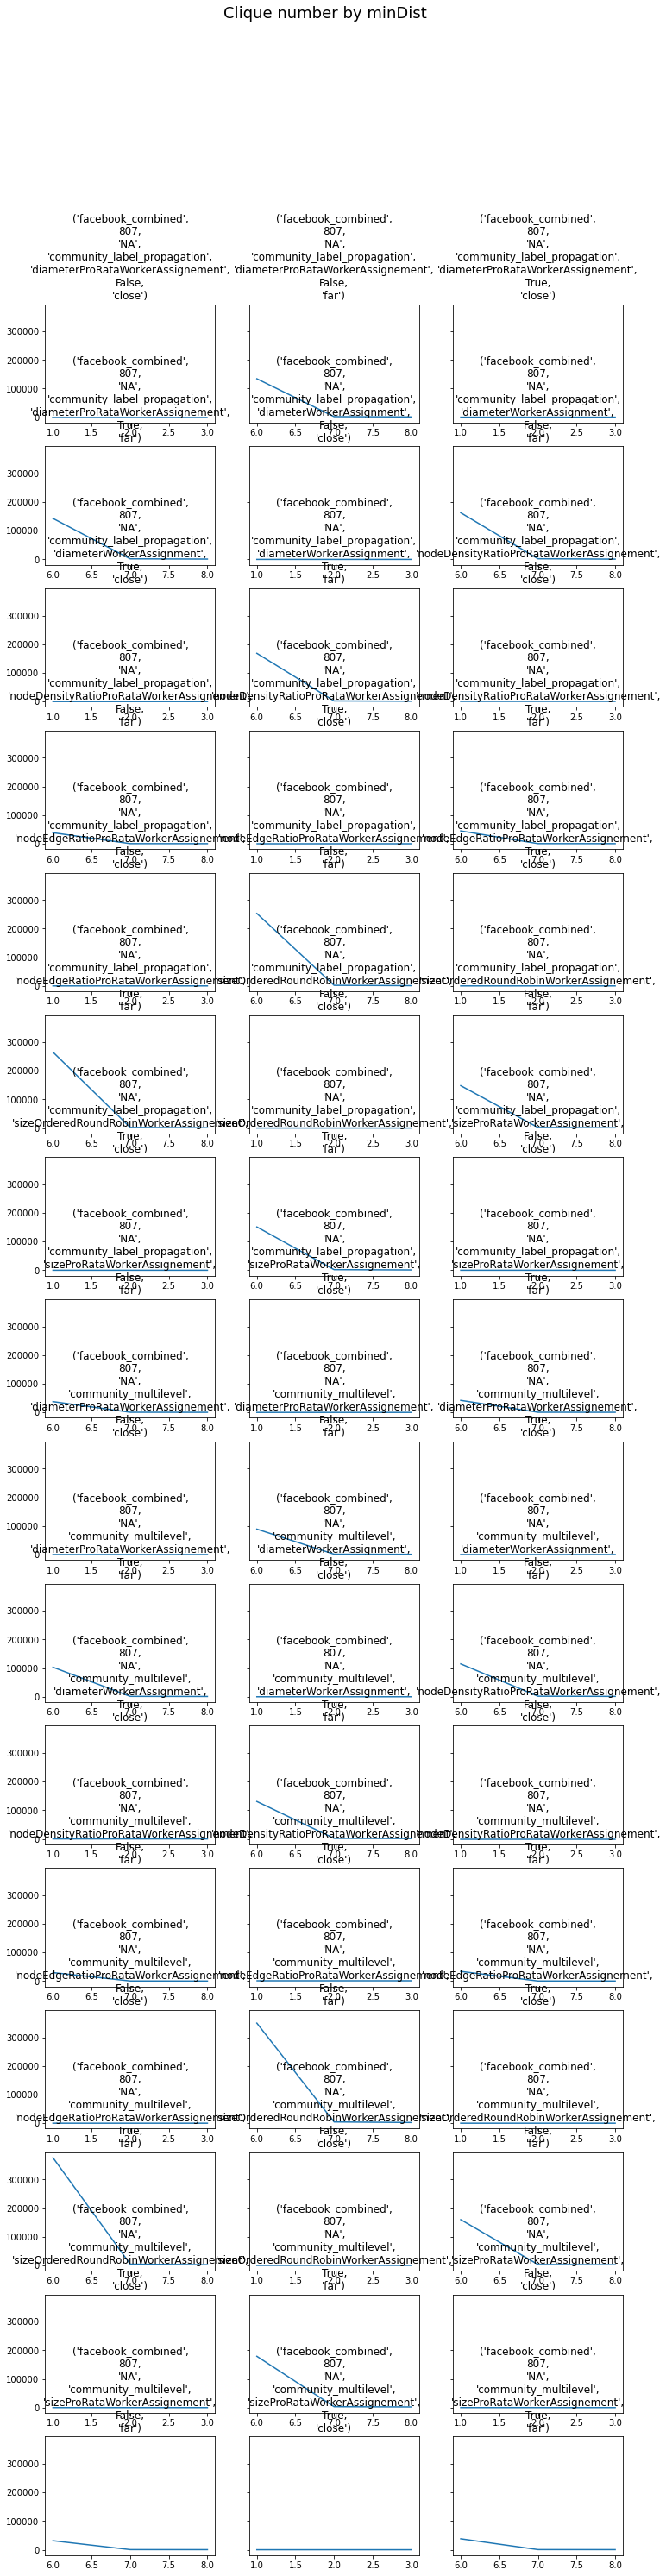

In [7]:
fig,ax = plt.subplots(nrows = (nbRows+nbCol-1)//nbCol, ncols = min(nbCol,nbRows), sharey=True,figsize=(nbCol*4,3*nbRows//nbCol))
fig.suptitle("Clique number by minDist", fontsize=18)

for index, row in enumerate(groupDf):
    ax[index//nbCol][index%nbCol].plot(cliqueNumber[index].keys(), cliqueNumber[index].values())
    ax[index//nbCol][index%nbCol].set_title(',\n'.join(str(groupDf.keys()[index]).split(', ')))

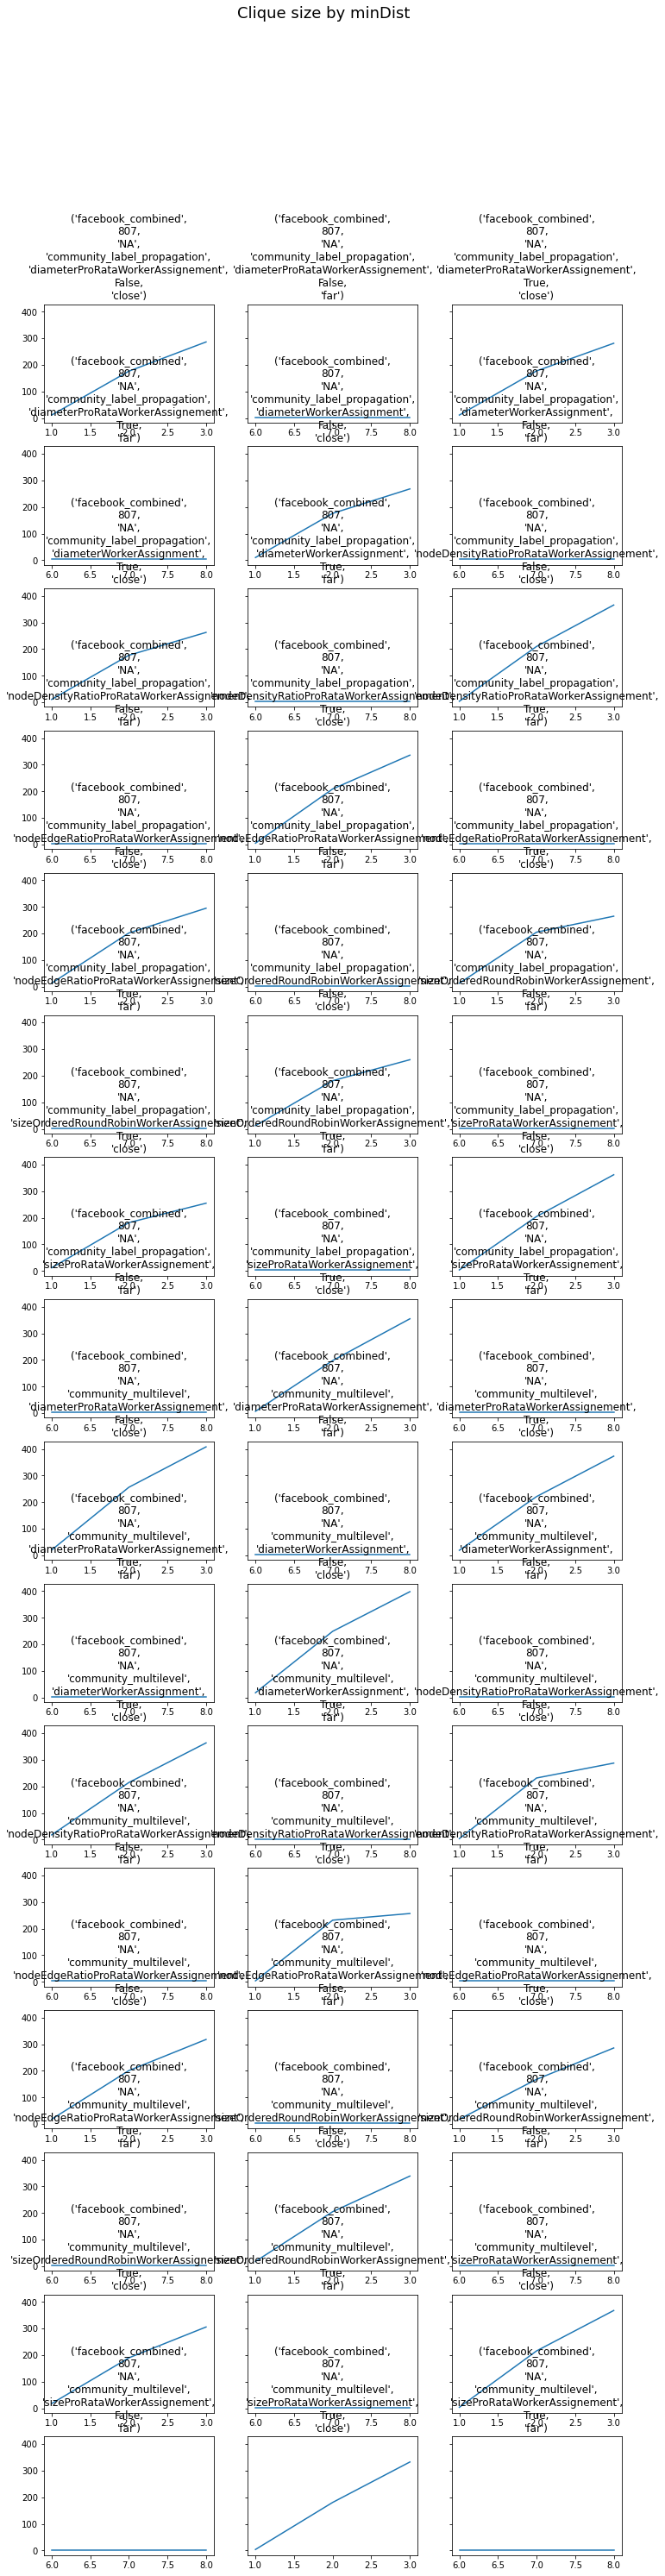

In [8]:
fig,ax = plt.subplots(nrows = (nbRows+nbCol-1)//nbCol, ncols = min(nbCol,nbRows), sharey=True,figsize=(nbCol*4,3*nbRows//nbCol))
fig.suptitle("Clique size by minDist", fontsize=18)

for index, row in enumerate(groupDf):
    ax[index//nbCol][index%nbCol].plot(cliqueSize[index].keys(), cliqueSize[index].values())
    ax[index//nbCol][index%nbCol].set_title(',\n'.join(str(groupDf.keys()[index]).split(', ')))

## Determination d'un k tq à 95% il n'y ait pas de worker colusion

In [9]:
def workerThreshold(cliqueSize, minDist, threshold, imgPath = None):
    cliqueSizeByMinDist = [ element.get(minDist) for element in cliqueSize if element.get(minDist) is not None]
    
    maxCliqueSize = max(cliqueSizeByMinDist)
    minCliqueSize = min(cliqueSizeByMinDist)

    fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize = (10,4))
    
    
    ##todo faire apparaitre le nb de workers considéré (ici 807)
    fig1.suptitle("Seuil de taille de cliques de workers distants d'au plus " + str(minDist), fontsize=18)

    ax1[0].hist(cliqueSizeByMinDist)
    
    
    bins=np.arange(minCliqueSize,maxCliqueSize+2, step=1)
    

    bar_heights, _, _ = ax1[1].hist(cliqueSizeByMinDist, cumulative=True, density=True, bins = bins, histtype="step")

    xThreshold = 0
    for index, v in enumerate(bar_heights):
        if v >= threshold:
            xThreshold = bins[index]
            break    
    ax1[1].axhline(threshold, color='r', linestyle='dashed', linewidth=1)
    ax1[1].axvline(xThreshold, color='r', linestyle='dashed', linewidth=1)
    
    ax1[1].text(xThreshold + 0.7, 0.025, xThreshold).set_color('red')
    ax1[1].text(minCliqueSize, threshold + 0.02 , threshold).set_color('red')
    
    ax1[1].set_title("minDist = {} threshold = {}".format(minDist, threshold))

    if imgPath is not None:
        fig1.savefig(imgPath)
            
    return xThreshold


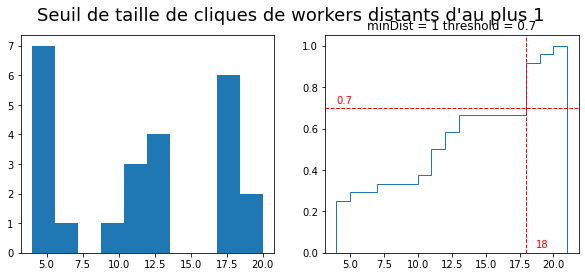

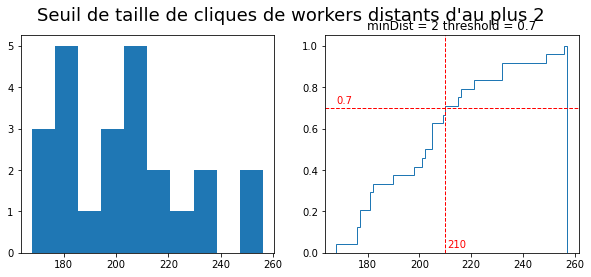

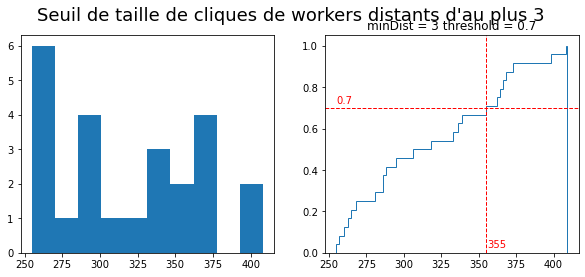

In [12]:
for minDist in range(1,4):
    workerThreshold(cliqueSize, minDist, 0.95)

Pour que 95% des executions n'aient pas de collusion il faut un nombre de workers t (sur n workers) min de xThreshold pour une minDist donnée 

Ici pour un distance maximale interworkers de 3 on a 95% des executions dont la clique maximale comprend 390 workers sur 807
Ainsi si on considère qu'une clique est potentiellement malveillante avec des workers de distance maximale de 3 il faudra prendre au moins 390 workers parmis les 807

Trouver la racine positive du polynome x² + x - nWorkers pour trouver la borne maximale de workers malveillants

In [11]:
import numpy.polynomial.polynomial as nppol

int(nppol.polyroots([-495, 1, 1])[1])

21

Le seuil de workers malveillants est de 27 sur un total de 807 workers et de + de 4000 votants
Ce nombre respecte la contrainte du (n-t²) workers inactifs

Note par rapport aux résultats sur la détéction de communauté vs Order based : Des résultats en seuils assez similaire, cependant on observe pour la partie CD une hausse beaucoup plus linéaire du % par rapport au nb de noeuds dans la clique 